In [233]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [234]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
pretty_midi.pretty_midi.MAX_TICK = 1e10


# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [235]:
data_dir = "C:\\Users\\adamc\\MusicGenAI\\ABBA"
filenames = glob.glob(str(data_dir+'/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 16


You will use three variables to represent a note when training the model: `pitch`, `step` and `duration`. The pitch is the perceptual quality of the sound as a MIDI note number. 
The `step` is the time elapsed from the previous note or start of the track.
The `duration` is how long the note will be playing in seconds and is the difference between the note end and note start times. 


Extract the notes from the sample MIDI file.

In [236]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [237]:
# Load a sample MIDI file to use as seed for generation
sample_file = filenames[0]  # Use first MIDI file
raw_notes = midi_to_notes(sample_file)
print(f"Loaded {len(raw_notes)} notes from {sample_file}")
raw_notes.head()

Loaded 291 notes from C:\Users\adamc\MusicGenAI\ABBA\Dancing_Queen.mid


,pitch,start,end,step,duration
0,71,19.500,19.989583,0.000,0.489583
1,73,20.000,20.130208,0.500,0.130208
2,71,20.125,20.234375,0.125,0.109375
3,69,20.250,21.734375,0.125,1.484375
4,73,22.000,22.479167,1.750,0.479167


It may be easier to interpret the note names rather than the pitches, so you can use the function below to convert from the numeric pitch values to note names. 
The note name shows the type of note, accidental and octave number
(e.g. C#4). 

To visualize the musical piece, plot the note pitch, start and end across the length of the track (i.e. piano roll). Start with the first 100 notes

In [238]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

In [239]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

## Create a MIDI file

You can generate your own MIDI file from a list of notes using the function below.

In [240]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

## Create the training dataset


Create the training dataset by extracting notes from the MIDI files. You can start by using a small number of files, and experiment later with more. This may take a couple minutes.

In [241]:
num_files = len(filenames)
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [242]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 6001


Next, create a `tf.data.Dataset` from the parsed notes.

In [243]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [244]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

You will train the model on batches of sequences of notes. Each example will consist of a sequence of notes as the input features, and the next note as the label. In this way, the model will be trained to predict the next note in a sequence. You can find a diagram describing this process (and more details) in [Text classification with an RNN](https://www.tensorflow.org/text/tutorials/text_generation).

You can use the handy [window](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) function with size `seq_length` to create the features and labels in this format.

In [245]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  
  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

Set the sequence length for each example. Experiment with different lengths (e.g. 50, 100, 150) to see which one works best for the data, or use [hyperparameter tuning](https://www.tensorflow.org/tutorials/keras/keras_tuner). The size of the vocabulary (`vocab_size`) is set to 128 representing all the pitches supported by `pretty_midi`.

In [246]:
seq_length = 16
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(16, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

The shape of the dataset is ```(100,1)```, meaning that the model will take 100 notes as input, and learn to predict the following note as output.

In [247]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (16, 3)
sequence elements (first 10): tf.Tensor(
[[0.5546875  0.         0.48958333]
 [0.5703125  0.5        0.13020833]
 [0.5546875  0.125      0.109375  ]
 [0.5390625  0.125      1.484375  ]
 [0.5703125  1.75       0.47916667]
 [0.5546875  0.5        0.06770833]
 [0.5546875  0.25       0.92708333]
 [0.5703125  1.25       0.453125  ]
 [0.5546875  0.5        0.0625    ]
 [0.5546875  0.25       0.50520833]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=68.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.375>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.24479166666666785>}


Batch the examples, and configure the dataset for performance.

In [248]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [249]:
train_ds.element_spec

(TensorSpec(shape=(64, 16, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Create and train the model

The model will have three outputs, one for each note variable. For `step` and `duration`, you will use a custom loss function based on mean squared error that encourages the model to output non-negative values.

In [250]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [251]:
def pitch_smoothness_reward(notes_array):
    """
    Penalizes large interval jumps.
    Good music typically has gradual pitch changes.
    
    notes_array shape: (seq_length, 3) where column 0 is pitch
    """
    if len(notes_array) < 2:
        return 0.0
    
    pitches = notes_array[:, 0]  # Extract pitch column
    pitch_diffs = np.diff(pitches)  # Calculate pitch jumps
    
    # Penalize large jumps (e.g., > 12 semitones = 1 octave)
    large_jumps = np.sum(np.abs(pitch_diffs) > 12)
    
    # Reward stepwise motion (small intervals)
    small_intervals = np.sum(np.abs(pitch_diffs) <= 2)
    
    reward = small_intervals * 0.5 - large_jumps * 1.0
    return reward

def pitch_variety_reward(notes_array):
    """
    STRONGLY penalizes consecutive repeats of the same pitch.
    Maximum 4 consecutive repeats allowed, heavily punished beyond that.
    """
    pitches = notes_array[:, 0]
    
    # Count consecutive repeats and apply harsh penalty
    consecutive_count = 1
    total_penalty = 0.0
    
    for i in range(1, len(pitches)):
        if pitches[i] == pitches[i-1]:
            consecutive_count += 1
            # STRONG penalty: ANY repeat beyond 4 is heavily punished
            if consecutive_count > 4:
                total_penalty += 0.6  # Severe penalty per extra repeat
        else:
            consecutive_count = 1
    
    # Baseline: reward for not having repeats, subtract heavy penalty if repeats exist
    # This ensures repeats heavily push reward negative
    reward = 1.0 - total_penalty
    
    return reward
    

In [252]:
def compute_music_reward(generated_sequence, weights=None):
    """
    Combined reward function for evaluating music generation.
    
    Args:
        generated_sequence: numpy array of shape (seq_length, 3)
        weights: dict of reward component weights
    
    Returns:
        float: total reward score
    """
    if weights is None:
        weights = {
            'smoothness': 0.8,
            'variety': 2.0,  # Heavily prioritize variety over smoothness
            #'rhythm': 1.5,
            #'harmony': 0.5,
        }
    
    # Calculate individual rewards
    smoothness = pitch_smoothness_reward(generated_sequence)
    variety = pitch_variety_reward(generated_sequence)
    #rhythm = rhythm_stability_reward(generated_sequence)
    #harmony = harmonic_reward(generated_sequence)
    
    # Weighted sum
    total_reward = (
        weights['smoothness'] * smoothness +
        weights['variety'] * variety
    )


        # weights['smoothness'] * smoothness +
        # weights['rhythm'] * rhythm +
        # weights['variety'] * variety +
        # weights['harmony'] * harmony
    
    # Normalize to reasonable range
    total_reward = total_reward / sum(weights.values())
    
    return total_reward


In [253]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 16, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 128)       │     67,584 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration (Dense)    │ (None, 1)         │        129 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pitch (Dense)       │ (None, 128)       │     16,512 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ step (Dense)        │ (None, 1)         │        129 │ lstm_6[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,354 (329.51 KB)

 Trainable params: 84,354 (329.51 KB)

 Non-trainable params: 0 (0.00 B)

Testing the `model.evaluate` function, you can see that the `pitch` loss is significantly greater than the `step` and `duration` losses. 
Note that `loss` is the total loss computed by summing all the other losses and is currently dominated by the `pitch` loss.

In [254]:
losses = model.evaluate(train_ds, return_dict=True)
losses

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - duration_loss: 0.4563 - loss: 7.3781 - pitch_loss: 4.8099 - step_loss: 2.1119


c:\Users\adamc\miniconda3\envs\MusAI\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


{'duration_loss': 0.45628005266189575,
 'loss': 7.378124713897705,
 'pitch_loss': 4.809910774230957,
 'step_loss': 2.111933708190918}

One way balance this is to use the `loss_weights` argument to compile:

In [255]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

The `loss` then becomes the weighted sum of the individual losses.

In [256]:
model.evaluate(train_ds, return_dict=True)

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - duration_loss: 0.4563 - loss: 2.8087 - pitch_loss: 4.8099 - step_loss: 2.1119


{'duration_loss': 0.45628005266189575,
 'loss': 2.808708667755127,
 'pitch_loss': 4.809910774230957,
 'step_loss': 2.111933708190918}

Train the model.

In [257]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}.weights.h5',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [258]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - duration_loss: 0.2574 - loss: 2.0339 - pitch_loss: 3.5630 - step_loss: 1.5983
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - duration_loss: 0.2414 - loss: 1.8435 - pitch_loss: 3.0547 - step_loss: 1.4494
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - duration_loss: 0.2357 - loss: 1.8148 - pitch_loss: 3.0089 - step_loss: 1.4287
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - duration_loss: 0.2317 - loss: 1.7923 - pitch_loss: 2.9692 - step_loss: 1.4122
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - duration_loss: 0.2239 - loss: 1.7771 - pitch_loss: 2.9497 - step_loss: 1.4057
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - duration_loss: 0.2178 - loss: 1.7574 - pitch_loss: 2.9139 - step_loss: 1.3939
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - duration_loss: 0.2153 - loss: 1.7448 - pitch_loss: 2.8691 - step_loss: 1.3861
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - duration_loss: 0.2111 - loss: 1.7333 -

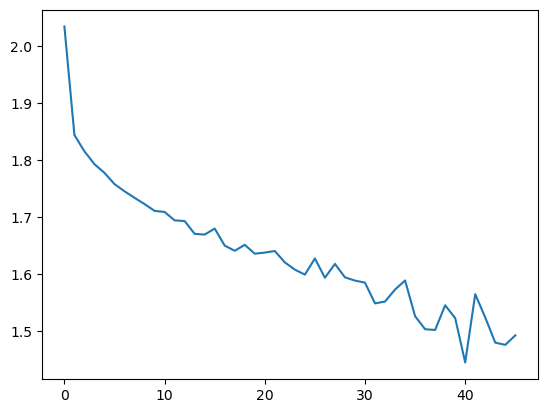

In [259]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [260]:
# RL Fine-tuning Phase
# Uses the reward functions defined earlier to improve the model

def rl_train_step(input_sequences, discount_factor=0.99):
    """
    Single RL training step using policy gradient weighted by music rewards.
    """
    with tf.GradientTape() as tape:
        predictions = model(input_sequences, training=True)
        pitch_logits = predictions['pitch']
        
        # Sample pitches from distribution (one pitch per batch element)
        pitch_samples = tf.random.categorical(pitch_logits, num_samples=1)
        pitch_samples = tf.squeeze(pitch_samples, axis=-1)
        
        # Compute policy loss (cross-entropy)
        sampled_pitch_log_probs = tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=pitch_samples, 
            logits=pitch_logits
        )
        
        # Compute rewards for each batch sample using combined reward function
        # Convert inputs and samples to numpy for batch processing
        input_seqs_np = input_sequences.numpy()  # Shape: (batch_size, seq_length, 3)
        pitch_samples_np = pitch_samples.numpy()  # Shape: (batch_size,)
        
        batch_rewards = []
        for i, input_seq in enumerate(input_seqs_np):
            # Append sampled pitch to input sequence to form complete sequence
            # Denormalize pitch: input_seq has normalized pitch values
            sampled_pitch = pitch_samples_np[i]
            # Create a new note with sampled pitch and dummy step/duration
            new_note = np.array([[sampled_pitch, 0, 0]])
            # Append to input sequence
            full_seq = np.vstack([input_seq, new_note])
            
            # Compute reward on the full sequence
            reward = compute_music_reward(full_seq)
            batch_rewards.append(reward)
        
        batch_rewards = tf.constant(batch_rewards, dtype=tf.float32)
        
        # Use rewards directly - higher rewards reduce loss, lower rewards increase it
        # Don't normalize aggressively to preserve reward signal
        baseline = tf.reduce_mean(batch_rewards)
        advantage = batch_rewards - baseline  # Center rewards but preserve scale
        
        # Weight policy loss by advantage (negative rewards increase loss, positive decrease it)
        weighted_loss = sampled_pitch_log_probs * tf.stop_gradient(advantage)
        rl_loss = tf.reduce_mean(weighted_loss)
    
    gradients = tape.gradient(rl_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return rl_loss

# Run RL fine-tuning for more epochs to allow model to learn reward
rl_epochs = 25
for epoch in range(rl_epochs):
    total_loss = 0.0
    num_batches = 0
    
    for batch_data in train_ds:
        inputs, labels = batch_data  # Unpack batch into inputs and labels
        loss = rl_train_step(inputs)
        total_loss += loss
        num_batches += 1
    
    avg_loss = total_loss / num_batches
    print(f"RL Epoch {epoch+1}/{rl_epochs}, Loss: {avg_loss:.4f}")

c:\Users\adamc\miniconda3\envs\MusAI\Lib\site-packages\keras\src\optimizers\base_optimizer.py:857: UserWarning: Gradients do not exist for variables ['duration/kernel', 'duration/bias', 'step/kernel', 'step/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


RL Epoch 1/25, Loss: -0.0015
RL Epoch 2/25, Loss: -0.0105
RL Epoch 3/25, Loss: -0.0094
RL Epoch 4/25, Loss: -0.0073
RL Epoch 5/25, Loss: -0.0152
RL Epoch 6/25, Loss: 0.0029
RL Epoch 7/25, Loss: -0.0098
RL Epoch 8/25, Loss: 0.0080
RL Epoch 9/25, Loss: -0.0043
RL Epoch 10/25, Loss: -0.0137
RL Epoch 11/25, Loss: -0.0071
RL Epoch 12/25, Loss: 0.0021
RL Epoch 13/25, Loss: 0.0149
RL Epoch 14/25, Loss: 0.0229
RL Epoch 15/25, Loss: 0.0237
RL Epoch 16/25, Loss: -0.0242
RL Epoch 17/25, Loss: -0.0176
RL Epoch 18/25, Loss: -0.0054
RL Epoch 19/25, Loss: -0.0096
RL Epoch 20/25, Loss: -0.0118
RL Epoch 21/25, Loss: -0.0236
RL Epoch 22/25, Loss: -0.0202
RL Epoch 23/25, Loss: -0.0036
RL Epoch 24/25, Loss: -0.0185
RL Epoch 25/25, Loss: 0.0040


## Generate notes

To use the model to generate notes, you will first need to provide a starting sequence of notes. The function below generates one note from a sequence of notes. 

For note pitch, it draws a sample from the softmax distribution of notes produced by the model, and does not simply pick the note with the highest probability.
Always picking the note with the highest probability would lead to repetitive sequences of notes being generated.

The `temperature` parameter can be used to control the randomness of notes generated. You can find more details on temperature in [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation).

In [261]:
def predict_next_note(
    notes: np.ndarray, 
    model: tf.keras.Model, 
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

Now generate some notes. You can play around with temperature and the starting sequence in `next_notes` and see what happens.

In [262]:
temperature = 0.8
num_predictions = 40

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  # Normalize the input_note before appending to input_notes
  normalized_note = np.array([pitch / vocab_size, step, duration])
  input_notes = np.append(input_notes, np.expand_dims(normalized_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━

In [263]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,64,0.260099,2.033208,0.260099,2.293307
1,64,0.126599,2.271084,0.386697,2.657781
2,64,0.374767,2.120448,0.761464,2.881913
3,64,0.360139,2.228648,1.121604,3.350252
4,64,0.618217,1.769073,1.739821,3.508894
5,64,0.490910,2.677263,2.230731,4.907993
6,64,0.363705,1.938587,2.594435,4.533022
7,64,0.801989,1.820234,3.396425,5.216659
8,64,0.240992,2.684036,3.637417,6.321453
9,64,0.229924,2.298424,3.867341,6.165765


In [200]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name='Acoustic Grand Piano')
#display_audio(out_pm)

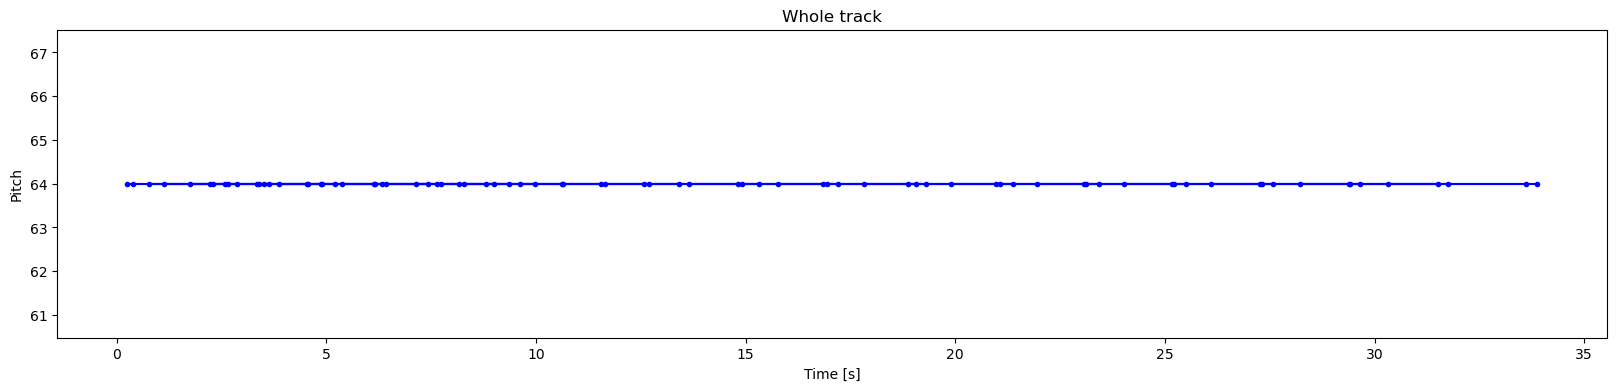

In [264]:
plot_piano_roll(generated_notes)

Check the distributions of `pitch`, `step` and `duration`.

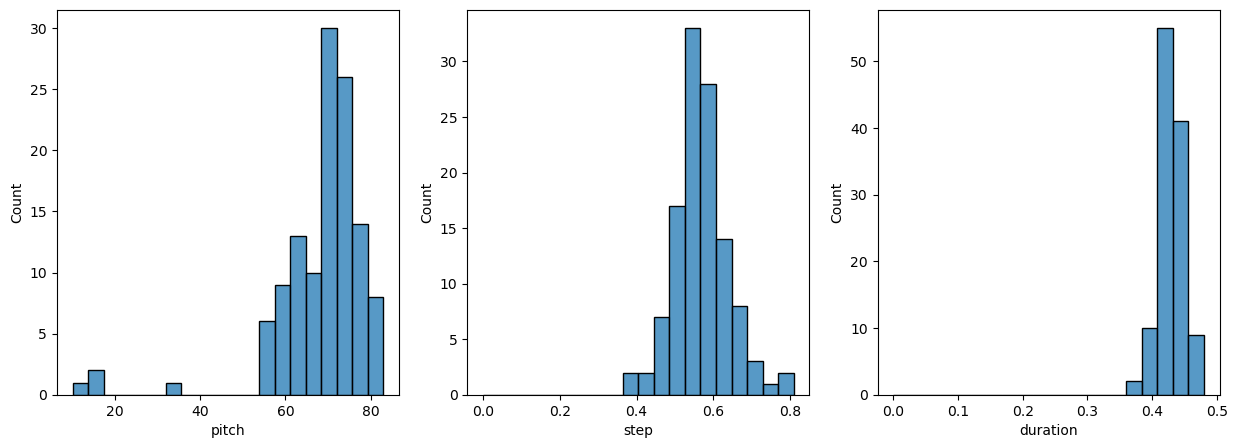

In [99]:
plot_distributions(generated_notes)

In the above plots, you will notice the change in distribution of the note variables.
Since there is a feedback loop between the model's outputs and inputs, the model tends to generate similar sequences of outputs to reduce the loss. 
This is particularly relevant for `step` and `duration`, which uses the MSE loss.
For `pitch`, you can increase the randomness by increasing the `temperature` in `predict_next_note`.


## Next steps

This tutorial demonstrated the mechanics of using an RNN to generate sequences of notes from a dataset of MIDI files. To learn more, you can visit the closely related [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial, which contains additional diagrams and explanations. 

One of the alternatives to using RNNs for music generation is using GANs. Rather than generating audio, a GAN-based approach can generate an entire sequence in parallel. The Magenta team has done impressive work on this approach with [GANSynth](https://magenta.tensorflow.org/gansynth). You can also find many wonderful music and art projects and open-source code on [Magenta project website](https://magenta.tensorflow.org/).